In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, model_selection, metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split


In [3]:
voice_data = pd.read_csv('voice.csv')
voice_data.head()


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [4]:
voice_data.isnull().sum().sum()

np.int64(0)

In [9]:
voice_data = pd.read_csv('voice.csv')

X = voice_data.drop(columns=['label'])
y = voice_data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

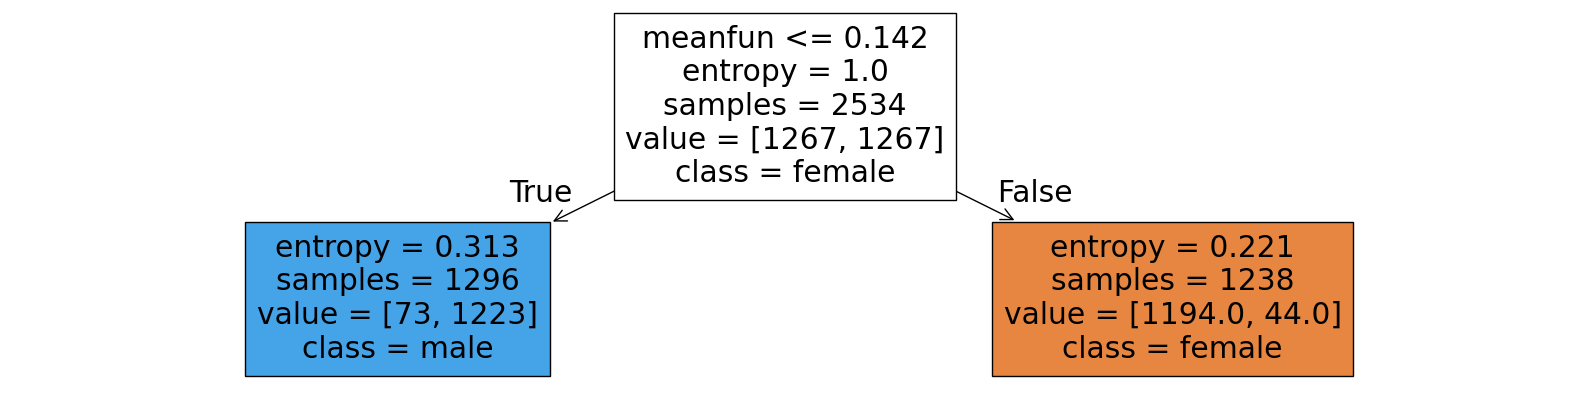

Признак: meanfun
Порог: 0.142
Доля удовлетворяющих условию: 51.1
Accuracy на тестовой выборке: 0.956


In [14]:
stump = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
stump.fit(X_train, y_train)

plt.figure(figsize=(20, 5))
plot_tree(stump, feature_names=X.columns, class_names=stump.classes_, filled=True)
plt.show()

# Ответы на вопросы:
feature = stump.tree_.feature[0]
threshold = stump.tree_.threshold[0]
feature_name = X.columns[feature]
threshold_rounded = round(threshold, 3)

# Доля, удовлетворяющая условию
mask = X_train.iloc[:, feature] <= threshold
fraction = round(mask.sum() / len(X_train) * 100, 1)

# Accuracy на тесте
y_pred_1 = stump.predict(X_test)
acc_1 = round(metrics.accuracy_score(y_test, y_pred_1), 3)

print(f"Признак: {feature_name}")
print(f"Порог: {threshold_rounded}")
print(f"Доля удовлетворяющих условию: {fraction}")
print(f"Accuracy на тестовой выборке: {acc_1}")


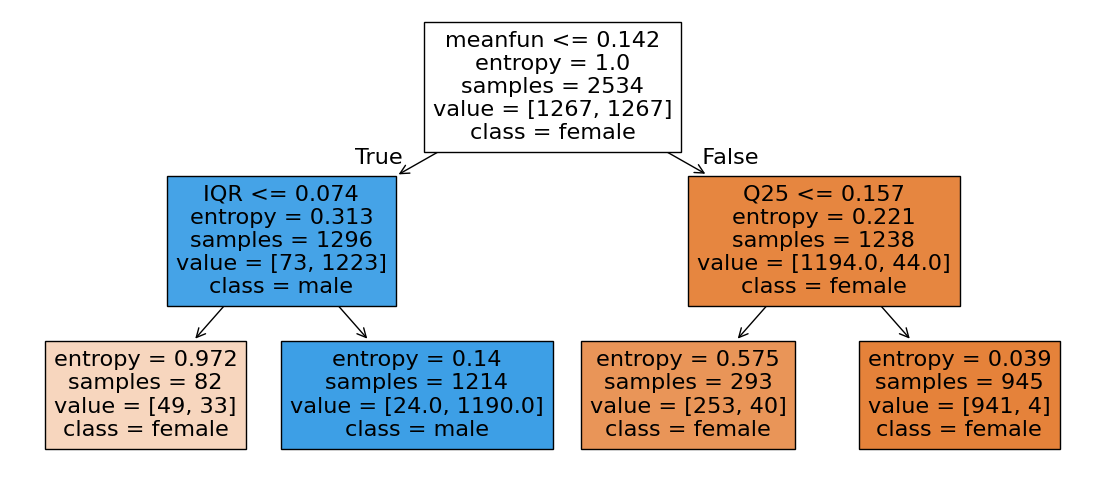

Используемые признаки: {'Q25', 'IQR', 'dfrange', 'meanfun'}
Количество листьев с 'female': 3
Accuracy на тестовой выборке: 0.962


In [15]:
dt_depth2 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)
dt_depth2.fit(X_train, y_train)

plt.figure(figsize=(14, 6))
plot_tree(dt_depth2, feature_names=X.columns, class_names=dt_depth2.classes_, filled=True)
plt.show()

# Используемые признаки
used_features = set(X.columns[dt_depth2.tree_.feature])
print("Используемые признаки:", used_features)

# Листья с предсказанием 'female'
n_female_leaves = sum(
    dt_depth2.classes_[np.argmax(v)] == 'female'
    for v in dt_depth2.tree_.value
    if sum(v[0]) > 0 and dt_depth2.tree_.children_left[np.where(dt_depth2.tree_.value == v)[0][0]] == -1
)

# Accuracy
acc_2 = round(metrics.accuracy_score(y_test, dt_depth2.predict(X_test)), 3)

print(f"Количество листьев с 'female': {n_female_leaves}")
print(f"Accuracy на тестовой выборке: {acc_2}")


In [16]:
dt_unlimited = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt_unlimited.fit(X_train, y_train)

depth = dt_unlimited.get_depth()
leaves = dt_unlimited.get_n_leaves()

acc_train = round(metrics.accuracy_score(y_train, dt_unlimited.predict(X_train)), 3)
acc_test = round(metrics.accuracy_score(y_test, dt_unlimited.predict(X_test)), 3)

print(f"Глубина дерева: {depth}")
print(f"Количество листьев: {leaves}")
print(f"Accuracy (train): {acc_train}")
print(f"Accuracy (test): {acc_test}")


Глубина дерева: 12
Количество листьев: 54
Accuracy (train): 1.0
Accuracy (test): 0.973


In [17]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [3, 4, 5, 10]
}

cv = StratifiedKFold(n_splits=5)
dt_base = DecisionTreeClassifier(random_state=0)

grid = GridSearchCV(dt_base, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_

acc_train_best = round(metrics.accuracy_score(y_train, best_model.predict(X_train)), 3)
acc_test_best = round(metrics.accuracy_score(y_test, best_model.predict(X_test)), 3)

print(f"Лучшая модель: {best_params}")
print(f"Accuracy (train): {acc_train_best}")
print(f"Accuracy (test): {acc_test_best}")


Лучшая модель: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 3}
Accuracy (train): 0.996
Accuracy (test): 0.97


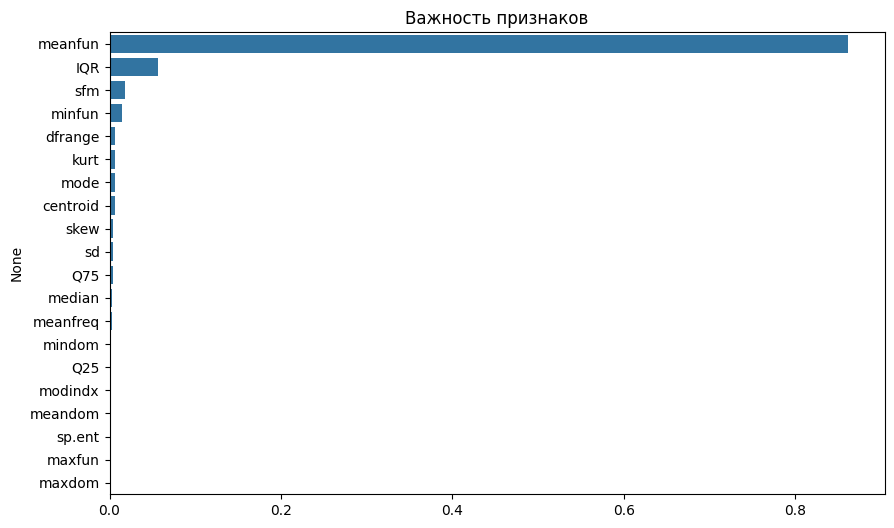

Топ-3 признака:
meanfun    0.861347
IQR        0.056810
sfm        0.018004
dtype: float64


In [18]:
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Топ-3 признака
top3 = feat_imp.head(3)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Важность признаков")
plt.show()

print("Топ-3 признака:")
print(top3)
